In [ ]:
import pickle
import torch
import pandas
import torchvision
import collections
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, confusion_matrix

writer = SummaryWriter()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
with open('valid.p', 'rb') as f:
  valid = pickle.load(f)
with open('test.p', 'rb') as f:
  test = pickle.load(f)
with open('train.p', 'rb') as f:
  train = pickle.load(f)

train_x, train_y = train['features'], train['labels']
test_x, test_y = test['features'], test['labels']
valid_x, valid_y = valid['features'], valid['labels']

In [ ]:
df = pandas.read_csv('/content/signname.csv')
counter = collections.Counter(train_y)

Text(0.5, 1.0, 'No entry')

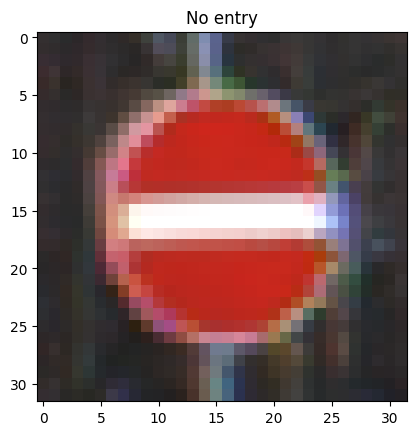

In [ ]:
plt.imshow(test_x[200])
id = test_y[200]
plt.title(df.iloc[id,1])

In [ ]:
class SignsDataset(Dataset):
  """Dataset class for storing and loading Traffic Sign images"""

  def __init__(self,
               images: list,
               targets: list,
               counter: collections.Counter,
               augmentation: bool = False
  ) -> None:
    """ Args:
            images (list): List of traffic sign images.
            targets (list): List of corresponding labels.
            counter (collections.Counter): Counter object, that contains amount
              of instances in each class.
            augmentation (bool): Wether to apply augmentation.
    """
    self.images = images
    self.targets = targets
    self.counter = counter
    self.augmentation = augmentation

  def __len__(self) -> int:
    return len(self.images)

  def augment(self, image: torch.Tensor) -> torch.Tensor:
    transformations = [transforms.RandomAffine([45, 180]), transforms.GaussianBlur(3),
                  transforms.RandomRotation([45, 180])]
    choice = transforms.RandomChoice(transformations)
    return choice(image)

  def __getitem__(self, idx: int) -> tuple:
    image = self.images[idx]
    totensor = transforms.ToTensor()
    image = totensor(image)
    target = self.targets[idx]

    if self.augmentation and self.counter[target] < 300:
       image = self.augment(image)

    return (image, target)

In [ ]:
train_dataset = SignsDataset(train_x, train_y, counter, True)
test_dataset = SignsDataset(test_x, test_y, counter)
valid_dataset = SignsDataset(valid_x, valid_y, counter)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [ ]:
class small_VGG16(nn.Module):
  """VGG16 architecture for 32x32 images"""

  def __init__(self) -> None:
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 32, (3,3), padding='same'),
        nn.ReLU(),
        nn.Conv2d(32, 32, (3,3)),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),
        nn.Dropout(p=0.25),
        nn.Conv2d(32, 64, (3,3), padding='same'),
        nn.ReLU(),
        nn.Conv2d(64, 64, (3,3)),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),
        nn.Dropout(p=0.25),
    )
    self.flatten = nn.Flatten()
    self.fc = nn.Sequential(
        nn.Linear(2304, 512),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(512, 43),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv(x)
    x = self.flatten(x)
    x = self.fc(x)
    return x

In [ ]:
model = small_VGG16().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

In [ ]:
def train() -> None:
  for epoch in range(15):
    loss_sum = 0
    for batch, (image, target) in enumerate(train_loader):
      image = image.to(dtype=torch.float32).to(device)
      target = target.to(device)
      output = model(image)
      loss = loss_fn(output, target)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_sum += loss.item()
      batch_num = len(train_loader)*epoch+batch
      writer.add_scalar(f'Loss/train', loss.item(), batch_num)
      writer.add_scalar(f'Accuracy/train', calc_acc(output, target), batch_num)

    print(f'epoch: {epoch}, loss: {loss_sum/len(train_loader)}')

def test_val(mode: str = 'test', print_report: bool = False) -> None:
  model.eval()
  loss_sum = 0
  acc_sum = 0
  loader = test_loader if mode == 'test' else valid_loader
  for batch, (image, target) in enumerate(loader):
      image = image.to(dtype=torch.float32).to(device)
      target = target.to(device)
      output = model(image)
      loss = loss_fn(output, target)
      loss_sum += loss.item()
      acc_sum += calc_acc(output, target)
  print(f'loss: {loss_sum/len(loader)}, acc: {acc_sum/len(loader)}')
  if print_report:
    calc_metrics(output, target)

def run(image: torch.Tensor) -> int:
  resize = torchvision.transforms.Resize((32,32))
  image = resize(image)
  image = image.to(device, dtype=torch.float32)
  image = image.unsqueeze(0)
  output = model(image)[0]
  return int(torch.argmax(output))

def calc_acc(output: torch.Tensor, target: torch.Tensor) -> float:
  output = torch.argmax(output, dim=1)
  acc = 0
  for x, y in zip(target, output):
    if x == y:
      acc += 1
  return acc/len(target)

def calc_metrics(outputs: torch.Tensor, targets: torch.Tensor) -> None:
  outputs, targets = outputs.cpu(), targets.cpu()
  outputs = torch.argmax(outputs, dim=1)
  print(classification_report(targets, outputs))
  print(confusion_matrix(targets, outputs))

In [ ]:
train()

epoch: 0, loss: 2.4289906640701435
epoch: 1, loss: 0.6419188075644129
epoch: 2, loss: 0.2964962788254899
epoch: 3, loss: 0.1931233419214978
epoch: 4, loss: 0.14835170437307918
epoch: 5, loss: 0.11527578559402815
epoch: 6, loss: 0.10124827383140869
epoch: 7, loss: 0.09484487078289557
epoch: 8, loss: 0.07895672789720051
epoch: 9, loss: 0.06917217794997509
epoch: 10, loss: 0.06365567321806927
epoch: 11, loss: 0.06134857311639387
epoch: 12, loss: 0.058160080235478855
epoch: 13, loss: 0.051985472038401946
epoch: 14, loss: 0.04867986972984748


In [ ]:
test_val('test')
test_val('valid')

loss: 0.1885236233421084, acc: 0.9562448614047451
loss: 0.1783366959542036, acc: 0.9686576354679802
